In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from cnnlearning import *
from learningutils import *
from patchextraction import *
from imageprosessing import *
from nearest_neighbors import *
from evaluation import *
from classificationutils import *
from sharedvariables import *
from vesseldetection import *
from generate_datasets import *
from plotutils import no_ticks, plot_images_as_grid
from guitools import CvRoipolySelector, CvPointSelector

import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

import os
plt.rcParams['image.cmap'] = 'gray'

# Jupyter Notebook settings

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%autosave 20
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Imports for data analysis
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 2500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 2000)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# size=25
size=10
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

def get_positions_from_csv(csv_file, frame_idx):
    df = pd.read_csv(csv_file)
    all_cell_positions = df[['X', 'Y']].to_numpy().astype(np.int32)
    all_cell_frame_indices = df[['Slice']].to_numpy().astype(np.int32)
    
    return all_cell_positions[np.where(all_cell_frame_indices == frame_idx)[0]]

video_sessions = get_video_sessions(should_have_marked_video=True)
# keep only the video sessions that have vessel masks
video_sessions = [vs for vs in video_sessions if vs.vessel_mask_confocal_file and vs.vessel_mask_oa850_file]

assert len(video_sessions) == 8
assert all([vs.vessel_mask_confocal_file for vs in video_sessions])
assert all([vs.vessel_mask_oa850_file for vs in video_sessions])
assert all([vs.video_oa790_file for vs in video_sessions])
assert all([vs.marked_video_oa790_file for vs in video_sessions])
assert all([len(vs.cell_position_csv_files) > 0 for vs in video_sessions])

vs = video_sessions[0]
# To see all the attributes of the VideoSession object do:
# vs.__dict__

Autosaving every 20 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


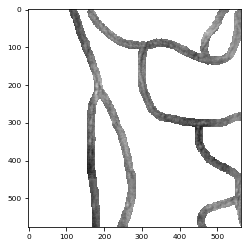

In [2]:
plt.imshow(np.ma.masked_array(vs.frames_oa790[0], ~vs.vessel_mask_confocal))

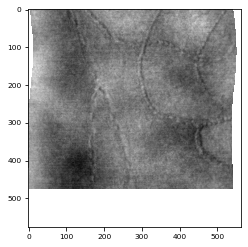

In [3]:
plt.imshow(vs.masked_frames_oa790[2])

In [2]:
class ImageRegistator(object):
    def __init__(self, source, target):
        self.source = source
        self.target = target
        
        # Warp affine doesn't work with boolean
        if source.dtype == np.bool8:
            self.source = np.float32(self.source)
        if target.dtype == np.bool8:
            self.target = np.float32(self.target)
            
        self.best_dice = dice(source, target)
        self.dices = [self.best_dice]
        self.vertical_displacement = 0
        self.horizontal_displacement = 0
        self.registered_source = source
   
    def register_vertically(self):
        dx = 0
        dys = np.int32(np.arange(1, 200, 1))



        # fig, axes = plt.subplots(len(dys), 1, figsize=(100, 100))

        dices = []
        for i, dy in enumerate(dys):
            translation = np.float32([[1, 0, dx], 
                                      [0, 1, dy]])

            height, width = self.source.shape[:2]

            translated_source = cv2.warpAffine(self.source, translation, (width, height))
            dice_v = dice(self.target, translated_source)
            dices.append(dice_v)
        
        # Get displacement that gives best dice coefficient.
        dy = dys[np.argmax(dices)]

        translation = np.float32([[1, 0, dx], 
                                  [0, 1, dy]])
        height, width = self.source.shape[:2]
        translated_source = cv2.warpAffine(self.source, translation, (width, height))

        self.registered_source = translated_source
        self.vertical_displacement = dy
        self.best_dice = max(dices)
        self.dices = dices
        
        return self.registered_source
    
    
    def apply_registration(self, im):
        dx, dy = self.horizontal_displacement, self.vertical_displacement

        translation = np.float32([[1, 0, dx], 
                                  [0, 1, dy]])
        height, width = im.shape[:2]
        im = cv2.warpAffine(im, translation, (width, height))
        
        return im
        
    @staticmethod
    def vertical_image_registration(self, source, ):
        dx = 0
        dys = np.int32(np.arange(1, 200, 1))

        source = vessel_mask_OA850
        target = vessel_mask_confocal

        # fig, axes = plt.subplots(len(dys), 1, figsize=(100, 100))

        dices = []
        for i, dy in enumerate(dys):
            translation = np.float32([[1, 0, dx], 
                                      [0, 1, dy]])

            height, width = source.shape[:2]

            translated_source = cv2.warpAffine(source, translation, (width, height))
            dice_v = dice(target, translated_source)
            dices.append(dice_v)
        
        return translated_source, dy
    

def match_template(image, template, 
                   method=cv2.TM_CCOEFF_NORMED):
    
    template_matching_methods = [cv2.TM_CCOEFF, cv2.TM_CCOEFF_NORMED, cv2.TM_CCORR,
                                 cv2.TM_CCORR_NORMED, cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED,  'template_match']
    assert method in template_matching_methods
    
    template = np.float32(template)
    image = np.float32(image)
    
    template_w, template_h = template.shape
    res = cv2.matchTemplate(image, template, method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
        
    cx, cy  = (np.floor(top_left[0] + template_w / 2), np.floor(top_left[1] + template_h / 2))
    plt.imshow(res)
    return (cx, cy), res


def find_bloodcell_correspondance(im_790, im_850, method='template_match', ret_correlation_im=False):
    im_790 = np.float32(im_790)
    im_850 = np.float32(im_850)

    template_matching_methods = [cv2.TM_CCOEFF, cv2.TM_CCOEFF_NORMED, cv2.TM_CCORR,
                                 cv2.TM_CCORR_NORMED, cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED, 
                                 'template_match']
    feature_matching_methods = ['surf']
    
    assert method in template_matching_methods or method in feature_matching_methods
    
    correlation_im = None
    if method in template_matching_methods:
        if method is 'template_match':
            # default template matching method is cross corellation
            method = cv2.TM_CCORR_NORMED
            
        h, w = im_790.shape
        centre_row, centre_col = int(h / 2), int(w / 2)
        template_cell = im_790[centre_row - 11:centre_row + 11,
                               centre_col - 11:centre_col + 11]
        (matched_x, matched_y), correlation_im = match_template(im_850, template_cell)
    elif method in feature_matching_methods:
        if method is 'surf':
            im_790 = np.uint8(im_790)
            im_890 = np.uint8(im_850)
            for i in range(400, 0, -10):
                # Initiate ORB detector
                surf = cv2.xfeatures2d.SURF_create(i)

                # find the keypoints and descriptors with ORB
                kp1, des1 = surf.detectAndCompute(im_790, None)
                kp2, des2 = surf.detectAndCompute(im_890, None)
                    
                if des1 is None or des2 is None or len(kp1) is 0 or len(kp2) is 0:
                    continue
                    
                # create BFMatcher object
                bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
                # Match descriptors.
                matches = bf.match(des1, des2)
                
                if len(matches) is 0:
                    continue
                # Sort them in the order of their distance.
                matches = sorted(matches, key = lambda x:x.distance)
                # Draw first match
                match = matches[0]
                img1_idx = match.queryIdx
                img2_idx = match.trainIdx

                # x - columns
                # y - rows
                # Get the coordinates
                x1, y1 = kp1[img1_idx].pt
                matched_x, matched_y = kp2[img2_idx].pt
                break
    else:
        raise Exception(f'No such method {method} for bloodcell correspondance.\n Use one of {template_matching_methods.extend(feature_matching_methods)}')
   
    if ret_correlation_im:
        return matched_x, matched_y, correlation_im
    else:
        return matched_x, matched_y

def create_average_images(video_session, patch_size=51, sigma=1, average_all_frames=True):
    # Input
    frame_idx = 0
    vs = video_session

    first_frame_oa790 = vs.frames_oa790[0]
    first_frame_oa850 = vs.frames_oa850[0]

    vessel_mask_confocal = vs.vessel_mask_confocal
    vessel_mask_oa850 = vs.vessel_mask_oa850

    std_image_confocal = vs.std_image_confocal
    std_image_oa850 = vs.std_image_oa850

    # plot
    fig, axes = plt.subplots(1, 6, figsize=(60, 13), constrained_layout=True)
    plt.rcParams['image.cmap'] = 'gray'
    plt.rcParams['axes.titlesize'] = 30
    plt.rcParams['figure.titlesize'] = 30
    # plt.tight_layout()

    print(vs.video_oa790_file)

    axes[0].imshow(first_frame_oa790)
    axes[0].set_title('First frame OA790');
    axes[1].imshow(first_frame_oa850)
    axes[1].set_title('First frame OA850')
    axes[2].imshow(std_image_confocal)
    axes[2].set_title('std confocal')
    axes[3].imshow(std_image_oa850)
    axes[3].set_title('std OA850');
    axes[4].imshow(vessel_mask_confocal)
    axes[4].set_title('vessel mask confocal')
    axes[5].imshow(vessel_mask_oa850)
    axes[5].set_title('vessel mask OA850');
    fig.suptitle(vs.video_oa790_file)
    
    image_registrator = ImageRegistator(source=vessel_mask_oa850, target=vessel_mask_confocal)
    image_registrator.register_vertically()

    # plot
    fig, axes = plt.subplots(1, 3, figsize=(30, 12))
    fig.suptitle('Image registration based on vessel mask')
    axes[0].imshow(image_registrator.target)
    axes[1].imshow(image_registrator.source)
    axes[1].set_title(f'Dice: {image_registrator.best_dice} \n oa790')

    axes[2].imshow(image_registrator.registered_source)
    axes[2].set_title(f'Dice: {image_registrator.best_dice} \n confocal')
    print('All oa850 images should be registered accordingly')
    
    print('Registering all oa850 frames')
    registered_frames_oa850 = vs.frames_oa850.copy()

    for i, frame in enumerate(registered_frames_oa850):
        registered_frames_oa850[i] = image_registrator.apply_registration(frame)

    # plot
    fig, axes = plt.subplots(1, 3, figsize=(30, 12))

    no_ticks(axes)
    fig.suptitle('Registrated oa850 frames')
    for ax, frame in zip(axes, registered_frames_oa850):
        ax.imshow(frame)


    # 
    frame_cell_positions = vs.cell_positions[frame_idx]
    frame_oa790 = vs.frames_oa790[frame_idx]
    frame_oa850 = vs.frames_oa850[frame_idx]

    # plot
    fig, axes = plt.subplots(1, 3, figsize=(30, 30))
    plt.rcParams['axes.titlesize'] = '20'

    axes[0].imshow(frame_oa790)
    axes[0].set_title('OA790')
    axes[0].scatter(frame_cell_positions[:, 0], frame_cell_positions[:, 1])
    axes[1].imshow(frame_oa850)
    axes[1].set_title('OA850')
    axes[2].imshow(image_registrator.apply_registration(first_frame_oa850))
    axes[2].set_title('Regitstered OA850')
    axes[2].scatter(frame_cell_positions[:, 0], frame_cell_positions[:, 1])
    print(f'Showing frame with index {frame_idx}')
    
    #### #### #### #### #### #### #### #### #### #### 
    window = 'select segment'
    

    # cv2.imshow(window, frame_OA790)
    registered_frame_oa850 = image_registrator.apply_registration(frame_oa850)
    registered_frame_oa850 = np.concatenate((registered_frame_oa850[..., None], 
                                             registered_frame_oa850[..., None],
                                             registered_frame_oa850[..., None]), axis=-1)
    
    all_cell_positions = np.empty((0, 2), dtype=np.int32)
    for frame_idx, cell_positions in vs.cell_positions.items():
        all_cell_positions = np.concatenate((all_cell_positions, cell_positions), axis=0)
    for x, y in vs.cell_positions[frame_idx]:
        registered_frame_oa850 = cv2.circle(registered_frame_oa850, (x, y), 1, (255, 0, 0))

    roipoly_selector = CvRoipolySelector(window, registered_frame_oa850)
    roipoly_selector.activate()

    selected_vessel_mask = roipoly_selector.mask.copy() 
    plt.imshow(frame_oa790 * selected_vessel_mask)
    
    all_cell_patches_oa790 = np.empty((0, patch_size, patch_size))
    all_cell_patches_oa850 = np.empty((0, patch_size, patch_size))
    for frame_idx, frame_cell_positions in vs.cell_positions.items():
        frame_oa790 = vs.frames_oa790[frame_idx]
        frame_oa850 = vs.frames_oa850[frame_idx]
        
        cell_patches_oa790 = extract_patches_at_positions(frame_oa790, frame_cell_positions,
                                                          mask=selected_vessel_mask,
                                                          patch_size=patch_size)
        cell_patches_oa850 = extract_patches_at_positions(image_registrator.apply_registration(frame_oa850), frame_cell_positions,
                                                          mask=selected_vessel_mask,
                                                          patch_size=patch_size)

        all_cell_patches_oa790 = np.concatenate((all_cell_patches_oa790, cell_patches_oa790))
        all_cell_patches_oa850 = np.concatenate((all_cell_patches_oa850, cell_patches_oa850))
        if not average_all_frames:
            break
    
    for i, (cell_patch_oa790, cell_patch_oa850) in enumerate(zip(all_cell_patches_oa790, all_cell_patches_oa850)):
        all_cell_patches_oa790[i] = mh.gaussian_filter(cell_patch_oa790, sigma)
        all_cell_patches_oa850[i] = mh.gaussian_filter(cell_patch_oa850, sigma)
        
    avg_cell_oa790 = np.average(all_cell_patches_oa790, axis=0)
    avg_cell_oa850 = np.average(all_cell_patches_oa850, axis=0)

    # plot
    plot_images_as_grid(cell_patches_oa790)
    plot_images_as_grid(cell_patches_oa850)

    fig, axes = plt.subplots(1, 2)

    axes[0].imshow(avg_cell_oa790)
    axes[1].imshow(avg_cell_oa850)
    
    avg_cell_oa790_clone = avg_cell_oa790.copy()
    avg_cell_oa850_clone = avg_cell_oa850.copy()

    # The template is in the middle of the average cell oa790 
    h, w = avg_cell_oa790.shape
    centre_row, centre_col = int(h / 2), int(w / 2)
    template_cell = avg_cell_oa790[centre_row - 11:centre_row + 11,
                                   centre_col - 11:centre_col + 11]


    cv2.rectangle(avg_cell_oa790_clone, (centre_row - 11, centre_col -11),  (centre_row + 11, centre_col + 11), color=(255, 0, 0))
    (cx, cy), _ = match_template(avg_cell_oa790, template_cell)
    (cx_850, cy_850), corellation_image = match_template(avg_cell_oa850, template_cell)

    # plot
    fig, axes = plt.subplots(1, 4)
    axes[0].imshow(avg_cell_oa790_clone)
    axes[0].scatter(cx, cy)
    axes[1].imshow(template_cell)
    axes[2].imshow(avg_cell_oa850)
    axes[2].scatter(cx_850, cy_850)
    axes[3].imshow(corellation_image, cmap='gray')

    template = template_cell.astype(np.float32)
    w, h = template.shape[::-1]
    # All the 6 methods for comparison in a list
    methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
               'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED', 'surf']
    for meth in methods:
        method = meth
        if meth != 'surf':
            method = eval(meth)        
        
        try:
            x, y, correlation_im = find_bloodcell_correspondance(avg_cell_oa790, avg_cell_oa850, method,  ret_correlation_im=True)
            print(f'Method {meth} ({x, y})')
        except:
            print(f'Method {meth} failed')
            
        try:
            cx, cy = find_bloodcell_correspondance(avg_cell_oa790, avg_cell_oa790, method)
        except:
            print(f'Method {meth} failed')
            
        fig, axes = plt.subplots(1, 3)
        no_ticks(axes)
        axes[0].imshow(avg_cell_oa790, cmap = 'gray')
        axes[0].set_title(f'Detected Point oa790 {avg_cell_oa790.shape}')
        axes[0].scatter(cx, cy)
        
        axes[1].scatter(cx, cy)
        axes[1].imshow(avg_cell_oa850, cmap = 'gray')
        axes[1].set_title(f'Detected Point oa850 {avg_cell_oa850.shape}')
        axes[1].scatter(x, y)
        
        if correlation_im is not None:
            print(avg_cell_oa790.shape)
            print(correlation_im.shape)

            axes[2].imshow(correlation_im, cmap='gray')
            axes[2].scatter(x, y)
            axes[2].set_title(f'correlation image oa850 {correlation_im.shape}')
        fig.suptitle(meth)

NameError: name 'cv2' is not defined

.\data\registered-videos\Subject47_Session375_OD_(0,-1)_1.04x1.04_3056_OA790nm1_extract_reg_cropped.avi
All oa850 images should be registered accordingly
Registering all oa850 frames
Showing frame with index 0
Method cv.TM_CCOEFF ((23.0, 36.0))
(51, 51)
(30, 30)
Method cv.TM_CCOEFF_NORMED ((23.0, 36.0))
(51, 51)
(30, 30)
Method cv.TM_CCORR ((23.0, 36.0))
(51, 51)
(30, 30)
Method cv.TM_CCORR_NORMED ((23.0, 36.0))
(51, 51)
(30, 30)
Method cv.TM_SQDIFF ((23.0, 36.0))
(51, 51)
(30, 30)
Method cv.TM_SQDIFF_NORMED ((23.0, 36.0))
(51, 51)
(30, 30)
Method surf ((20.12131690979004, 35.030296325683594))


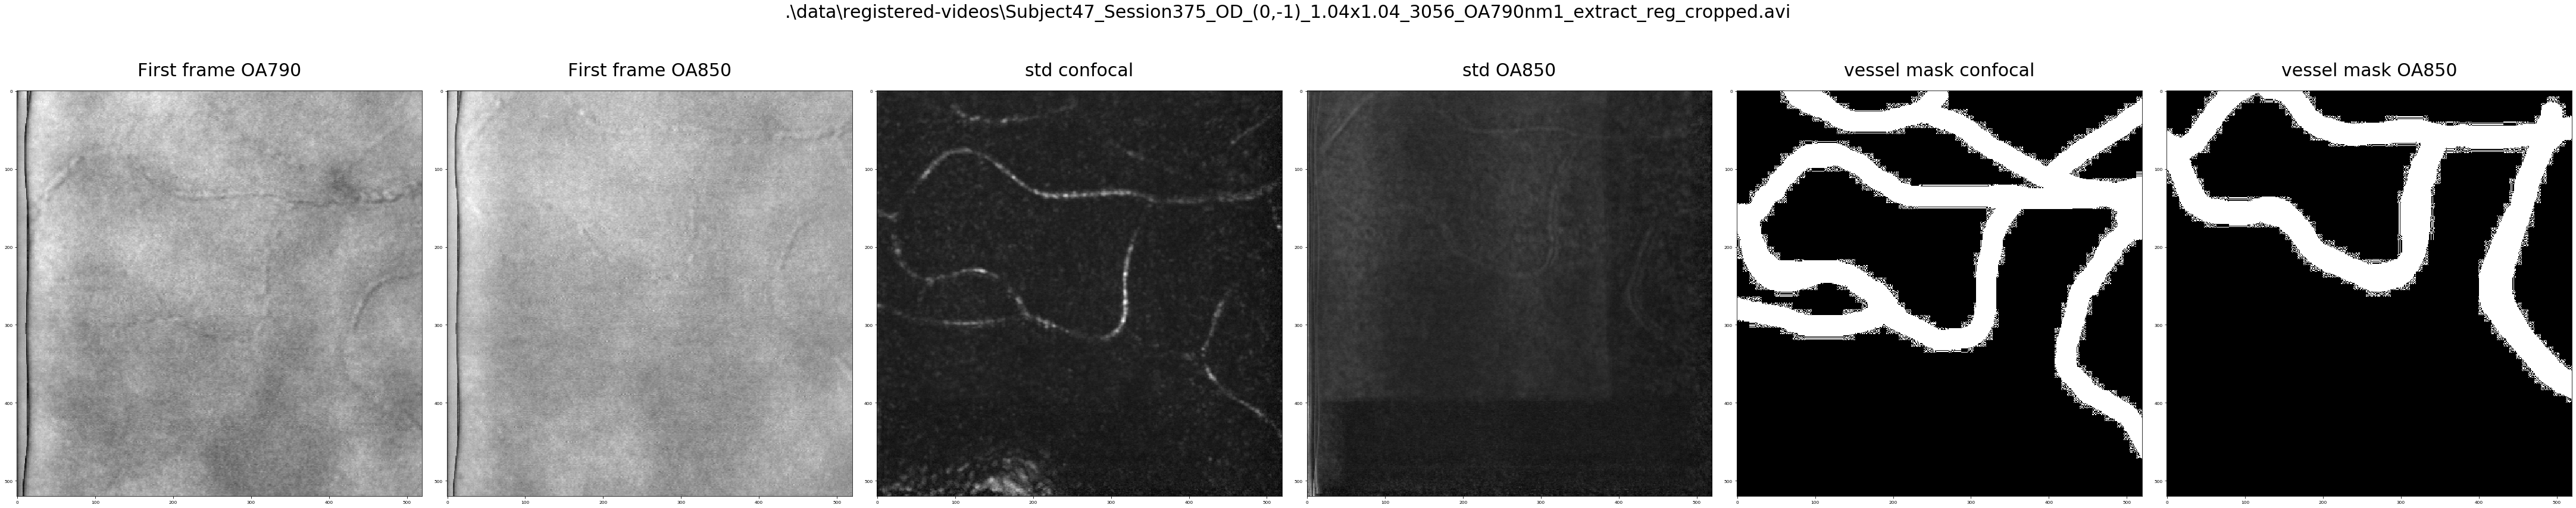

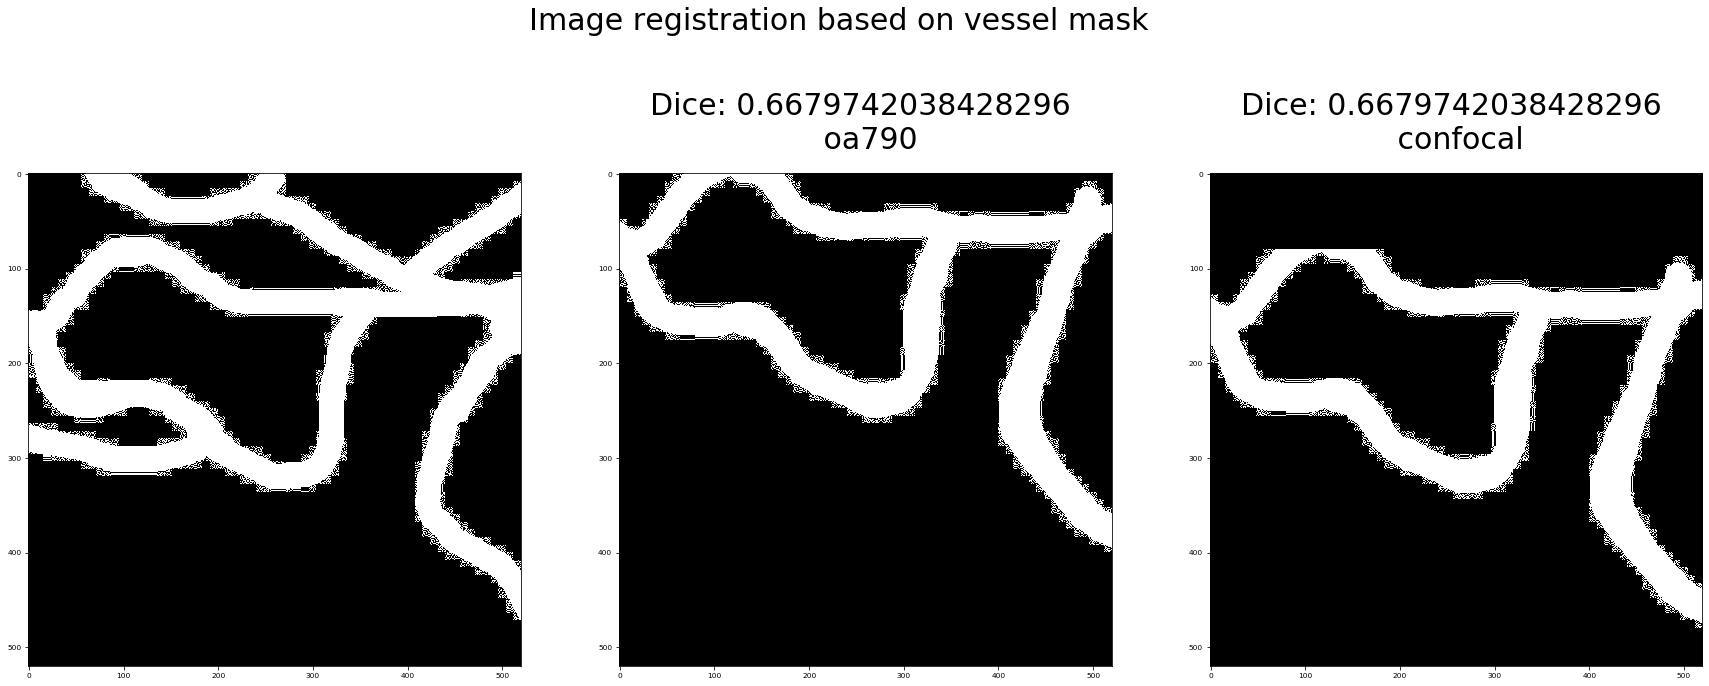

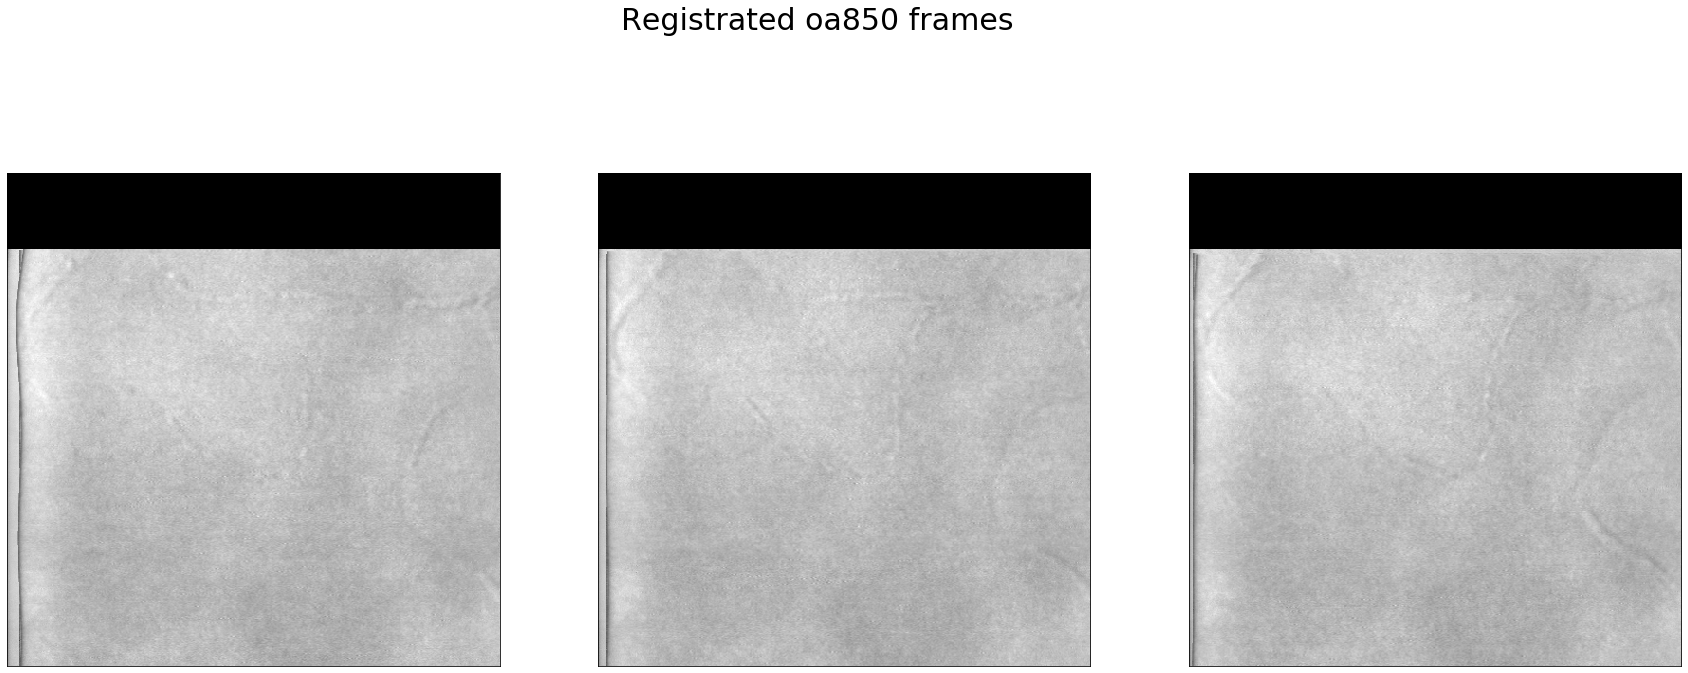

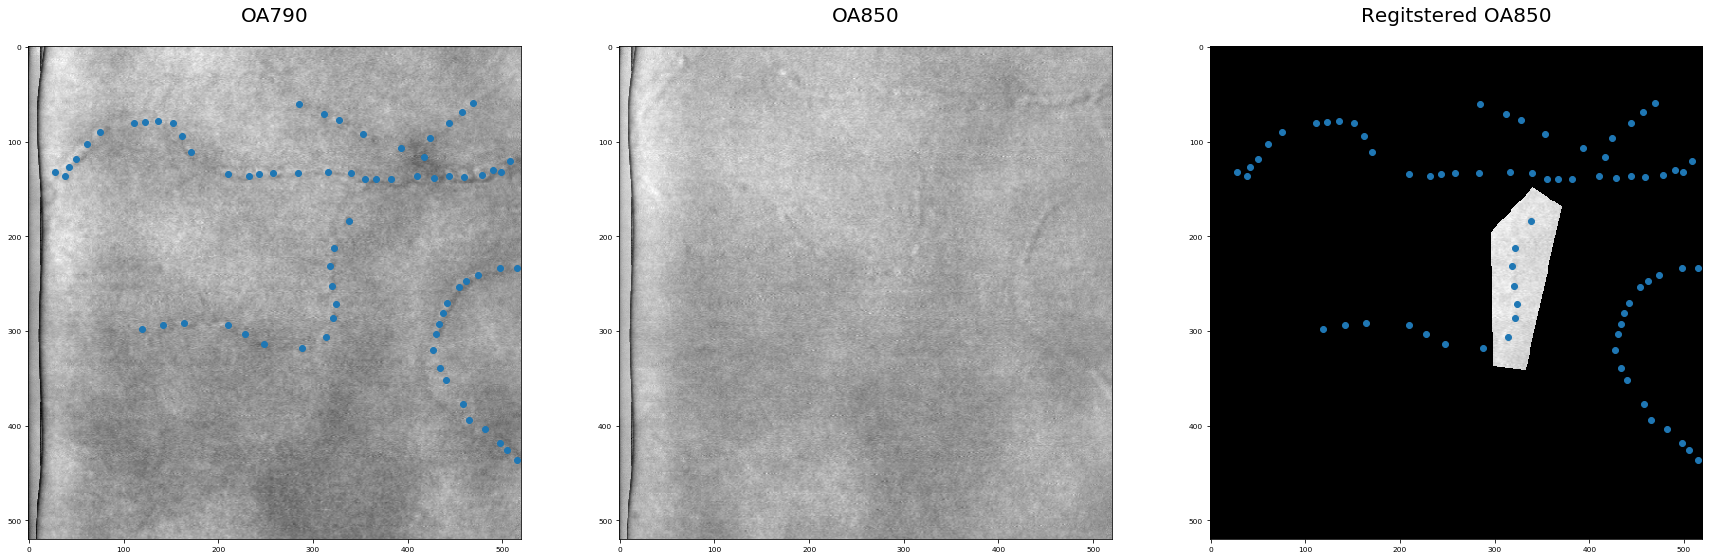

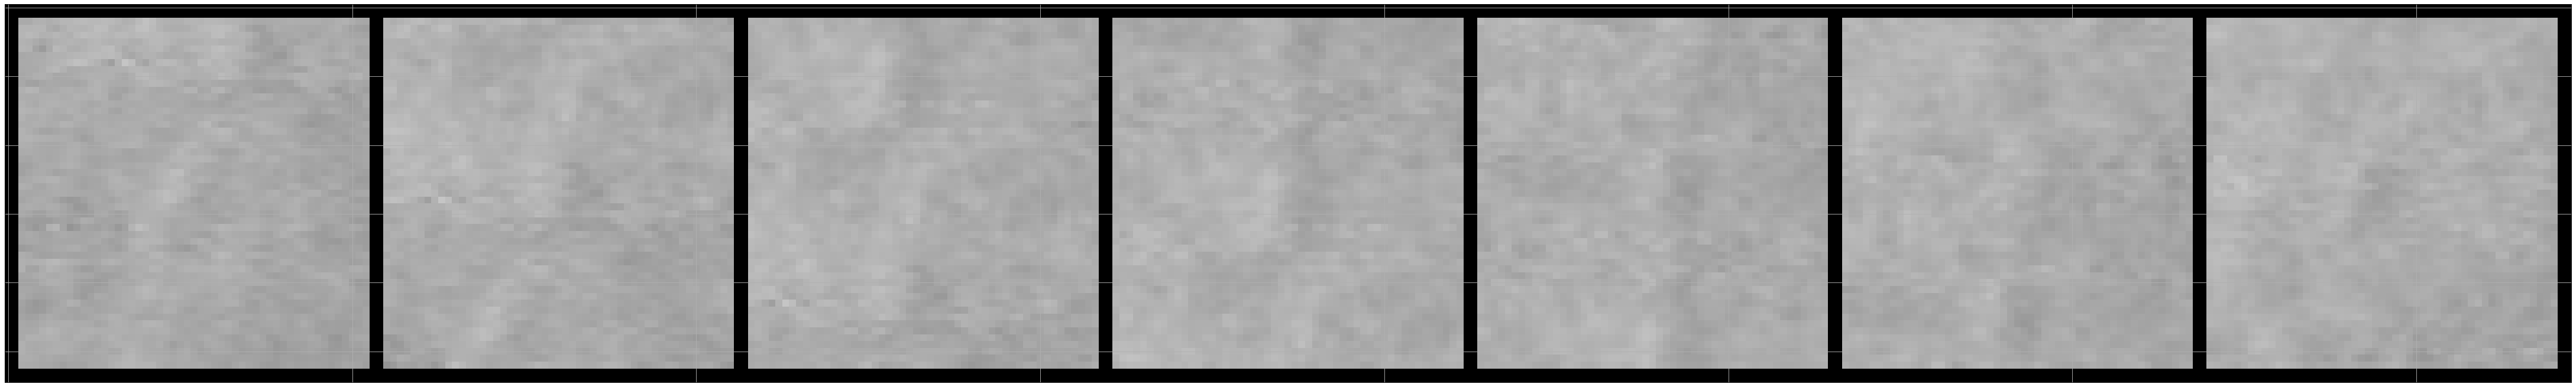

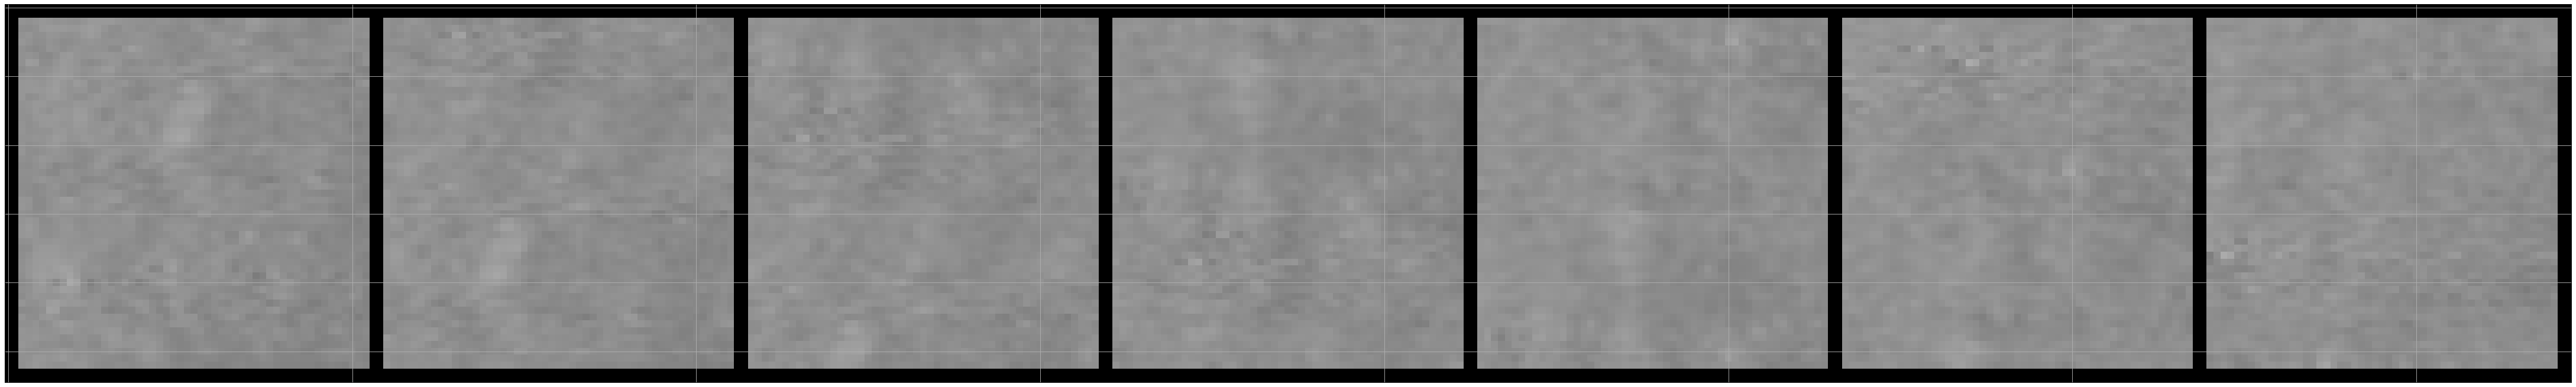

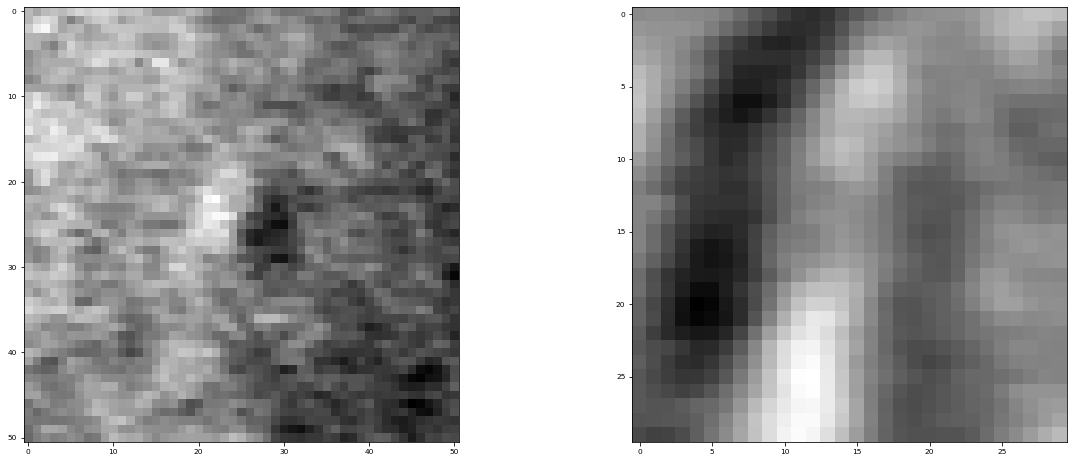

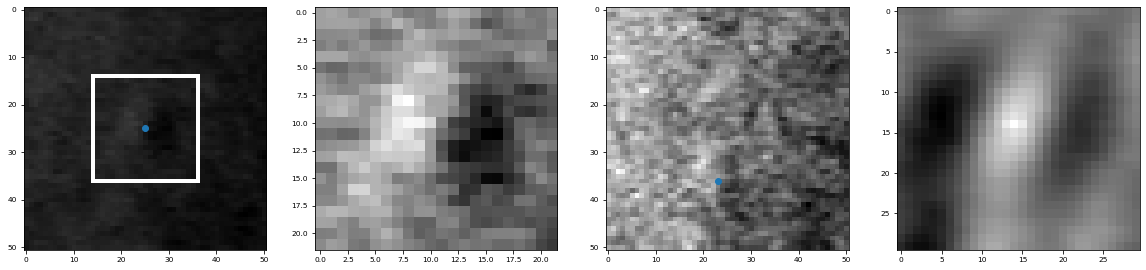

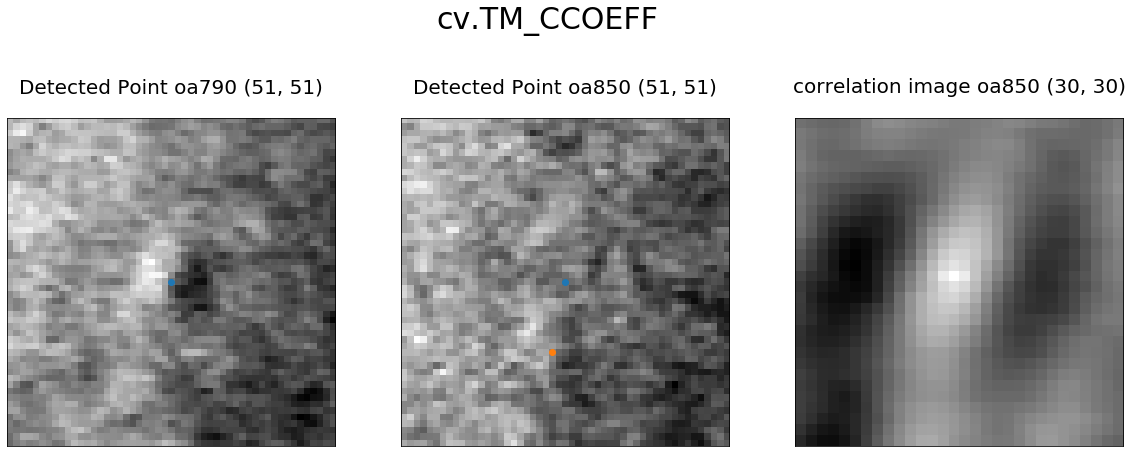

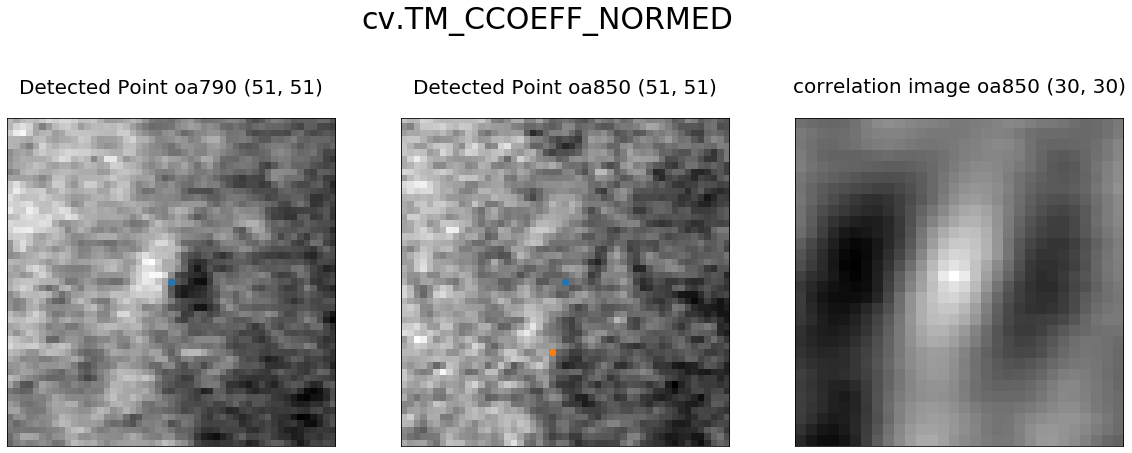

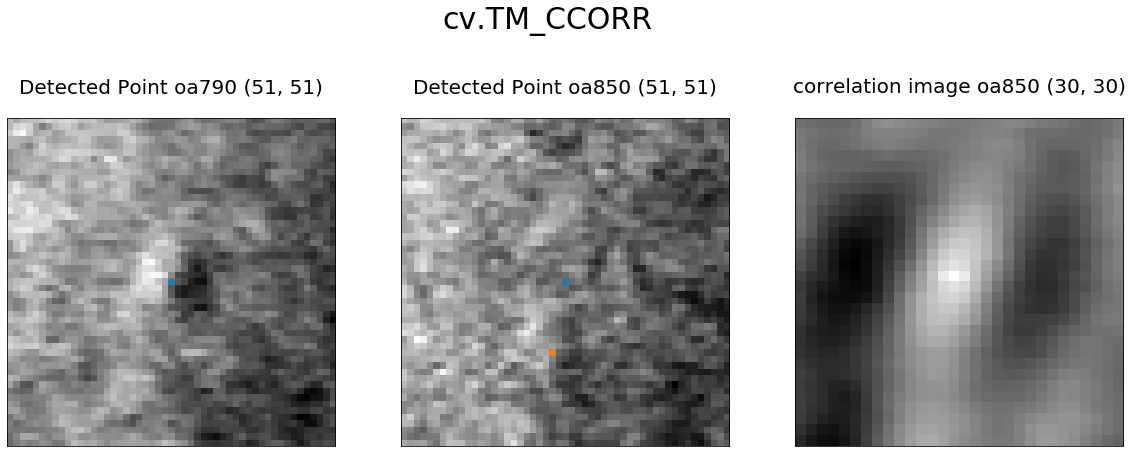

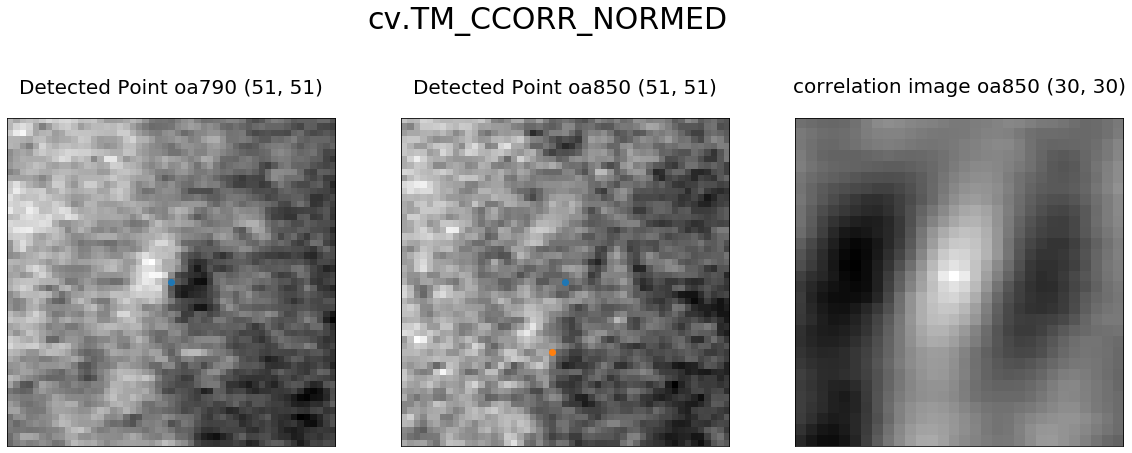

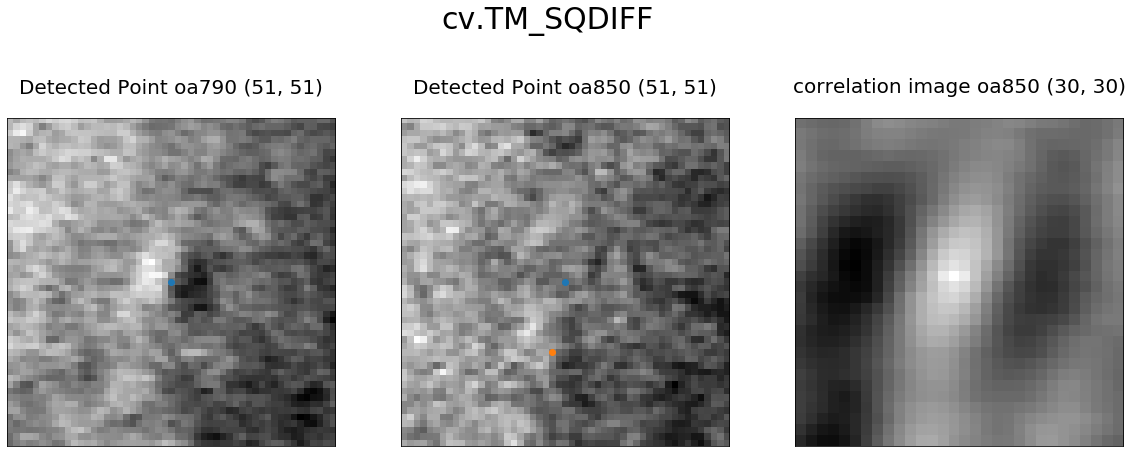

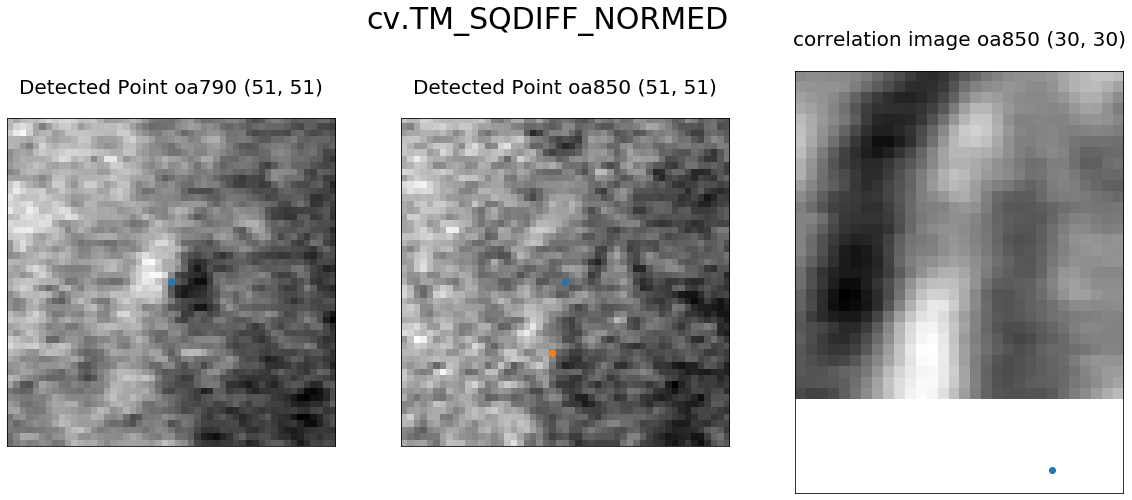

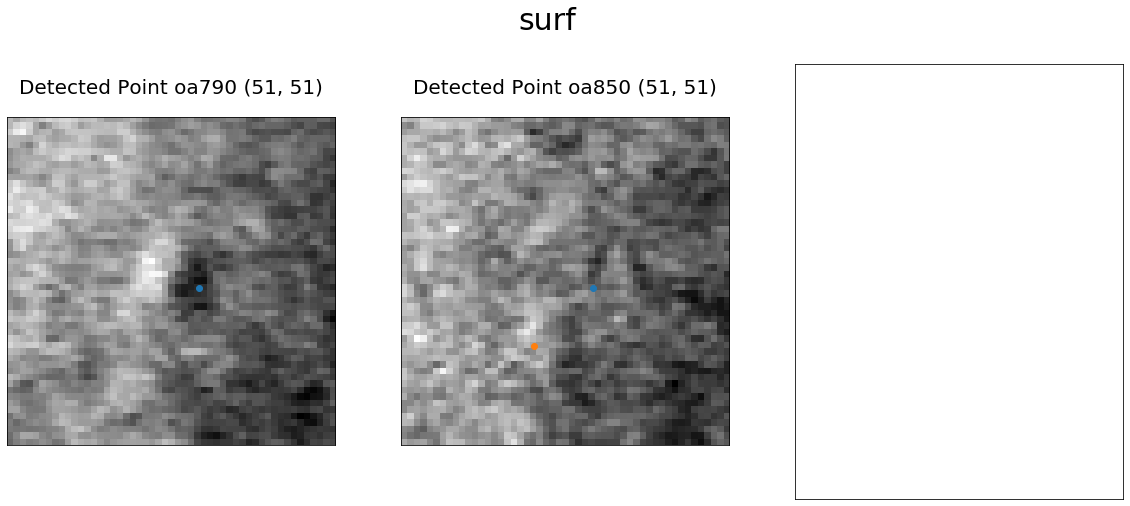

In [54]:
create_average_images(video_sessions[2], patch_size=51, sigma=0.2, average_all_frames=False)

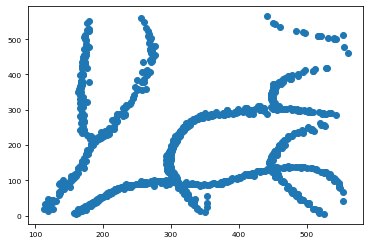

In [7]:
all_cell_positions = np.zeros((0, 2), dtype=np.int32)
for frame_idx, cell_positions in vs.cell_positions.items():
    all_cell_positions = np.concatenate((all_cell_positions, cell_positions), axis=0)

plt.scatter(all_cell_positions[:, 0], all_cell_positions[:, 1])

In [ ]:
_, axes = plt.subplots(len(video_sessions), 4, figsize=(40, 40))

no_ticks(axes)

for i, (vs, ax) in enumerate(zip(video_sessions, axes)):
    first_frame_oa790 = vs.frames_oa790[0]
    first_frame_oa850 = vs.frames_oa850[0]
    vessel_mask_confocal = vs.vessel_mask_confocal
    vessel_mask_oa850 = vs.vessel_mask_oa850
    ax[0].imshow(first_frame_oa790, cmap='gray')
    ax[0].set_title(i)
    ax[1].imshow(first_frame_oa850, cmap='gray')
    ax[2].imshow(vessel_mask_confocal)
    ax[3].imshow(vessel_mask_oa850)

In [ ]:
# Input
vs = video_sessions[7]

#### #### #### #### #### #### #### ####
first_frame_oa790 = vs.frames_oa790[0]
first_frame_oa850 = vs.frames_oa850[0]

vessel_mask_confocal = vs.vessel_mask_confocal
vessel_mask_oa850 = vs.vessel_mask_oa850

std_image_confocal = vs.std_image_confocal
std_image_oa850 = vs.std_image_oa850

# plot
fig, axes = plt.subplots(1, 6, figsize=(60, 13), constrained_layout=True)
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['figure.titlesize'] = 30
# plt.tight_layout()

print(vs.video_oa790_file)

axes[0].imshow(first_frame_oa790)
axes[0].set_title('First frame OA790');
axes[1].imshow(first_frame_oa850)
axes[1].set_title('First frame OA850')
axes[2].imshow(std_image_confocal)
axes[2].set_title('std confocal')
axes[3].imshow(std_image_oa850)
axes[3].set_title('std OA850');
axes[4].imshow(vessel_mask_confocal)
axes[4].set_title('vessel mask confocal')
axes[5].imshow(vessel_mask_oa850)
axes[5].set_title('vessel mask OA850');
fig.suptitle(vs.video_oa790_file)
# fig.tight_layout()
pass

In [ ]:
image_registrator = ImageRegistator(source=vessel_mask_oa850, target=vessel_mask_confocal)
image_registrator.register_vertically()

# plot
fig, axes = plt.subplots(1, 3, figsize=(30, 12))
fig.suptitle('Image registration based on vessel mask')
axes[0].imshow(image_registrator.target)
axes[1].imshow(image_registrator.source)
axes[1].set_title(f'Dice: {image_registrator.best_dice} \n oa790')

axes[2].imshow(image_registrator.registered_source)
axes[2].set_title(f'Dice: {image_registrator.best_dice} \n confocal')
print('All oa850 images should be registered accordingly')

In [ ]:
print('Registering all oa850 frames')
registered_frames_oa850 = vs.frames_oa850.copy()

for i, frame in enumerate(registered_frames_oa850):
    registered_frames_oa850[i] = image_registrator.apply_registration(frame)

# plot
fig, axes = plt.subplots(1, 3, figsize=(30, 12))

no_ticks(axes)
fig.suptitle('Registrated oa850 frames')
for ax, frame in zip(axes, registered_frames_oa850):
    ax.imshow(frame)

In [ ]:
# Input
frame_idx = 1

# 
frame_cell_positions = vs.cell_positions[frame_idx]
frame_oa790 = vs.frames_oa790[frame_idx - 1]
frame_oa850 = vs.frames_oa850[frame_idx - 1]

# plot
fig, axes = plt.subplots(1, 3, figsize=(30, 30))
plt.rcParams['axes.titlesize'] = '20'

axes[0].imshow(frame_oa790)
axes[0].set_title('OA790')
axes[0].scatter(frame_cell_positions[:, 0], frame_cell_positions[:, 1])
axes[1].imshow(frame_oa850)
axes[1].set_title('OA850')
axes[2].imshow(image_registrator.apply_registration(first_frame_oa850))
axes[2].set_title('Regitstered OA850')
axes[2].scatter(frame_cell_positions[:, 0], frame_cell_positions[:, 1])
print(f'Showing frame with index {frame_idx}')
pass

In [ ]:
window = 'select segment'

# cv2.imshow(window, frame_OA790)
registered_frame_oa850 = image_registrator.apply_registration(frame_oa850)
registered_frame_oa850 = np.concatenate((registered_frame_oa850[..., None], 
                                         registered_frame_oa850[..., None],
                                         registered_frame_oa850[..., None]), axis=-1)
for x, y in frame_cell_positions:
    registered_frame_oa850 = cv2.circle(registered_frame_oa850, (x, y), 1, (255, 0, 0))
    
roipoly_selector = CvRoipolySelector(window, registered_frame_oa850)
roipoly_selector.activate()

selected_vessel_mask = roipoly_selector.mask.copy() 
plt.imshow(frame_oa790 * selected_vessel_mask)

patch_size = 75
# frame_OA790_marked = plt.imread(marked_video_OA790_filenames[idx])
# cell_patches_OA790_marked = extract_patches_at_positions(frame_OA790_marked, cell_positions, patch_size=patch_size)
cell_patches_oa790 = extract_patches_at_positions(frame_oa790, frame_cell_positions,
                                                  mask=selected_vessel_mask,
                                                  patch_size=patch_size)
cell_patches_oa850 = extract_patches_at_positions(image_registrator.apply_registration(frame_oa850), frame_cell_positions,
                                                  mask=selected_vessel_mask,
                                                  patch_size=patch_size)

avg_cell_oa790 = np.average(cell_patches_oa790, axis=0)
avg_cell_oa850 = np.average(cell_patches_oa850, axis=0)

# plot
plot_images_as_grid(cell_patches_oa790)
plot_images_as_grid(cell_patches_oa850)

fig, axes = plt.subplots(1, 2)

axes[0].imshow(avg_cell_oa790)
axes[1].imshow(avg_cell_oa850)

In [ ]:
avg_cell_oa790_clone = avg_cell_oa790.copy()
avg_cell_oa850_clone = avg_cell_oa850.copy()

# The template is in the middle of the average cell oa790 
h, w = avg_cell_oa790.shape
centre_row, centre_col = int(h / 2), int(w / 2)
template_cell = avg_cell_oa790[centre_row - 11:centre_row + 11,
                               centre_col - 11:centre_col + 11]


cv2.rectangle(avg_cell_oa790_clone, (centre_row - 11, centre_col -11),  (centre_row + 11, centre_col + 11), color=(255, 0, 0))
cx, cy = match_template(avg_cell_oa790, template_cell)
cx_850, cy_850 = match_template(avg_cell_oa850, template_cell)

# plot
fig, axes = plt.subplots(1, 3)
axes[0].imshow(avg_cell_oa790_clone)
axes[0].scatter(cx, cy)
axes[1].imshow(template_cell)
axes[2].imshow(avg_cell_oa850)
axes[2].scatter(cx_850, cy_850)

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

img = avg_cell_oa850
img2 = img.copy()
template = template_cell.astype(np.float32)
w, h = template.shape[::-1]
# All the 6 methods for comparison in a list
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
           'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED', 'surf']
for meth in methods:
    img = img2.copy()
    
    method = meth
    if meth != 'surf':
        method = eval(meth)        

    x, y = find_bloodcell_correspondance(avg_cell_oa790, avg_cell_oa850, method)
    
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.scatter(x, y)
    plt.suptitle(meth)
    plt.show()
pass

In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
img1 = np.round(avg_cell_oa790).astype(np.uint8)
img2 = np.round(avg_cell_oa850).astype(np.uint8)

# Initiate ORB detector
for i in range(1000, 0, -1):
    surf = cv2.xfeatures2d.SURF_create(10)

    # find the keypoints and descriptors with ORB
    kp1, des1 = surf.detectAndCompute(img1, None)
    kp2, des2 = surf.detectAndCompute(img2, None)

    if len(kp1) == 0 or len(kp2) == 0:
        continue
        
    print(len(kp1), des1.dtype)
    print(len(kp2), des2.dtype)
    
    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    # Match descriptors.
    matches = bf.match(des1, des2)
    if len(matches) == 0:
        continue
        
    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)
    # Draw first 10 matches.
    img3 = cv.drawMatches(img1, kp1, img2, kp2, matches[:1], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img3),plt.show()
    break
pass

In [ ]:
points = vs.cell_positions[1]


plt.scatter(points[:, 0], points[:, 1])

In [ ]:
points[:, 0]

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn import linear_model, datasets


n_samples = 1000
n_outliers = 50


X, y, coef = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=10,
                                      coef=True, random_state=0)

# Add outlier data
np.random.seed(0)
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

# Fit line using all data
lr = linear_model.LinearRegression()
lr.fit(X, y)

# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(coef, lr.coef_, ransac.estimator_.coef_)

lw = 2
plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.plot(line_X, line_y, color='navy', linewidth=lw, label='Linear regressor')
plt.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=lw,
         label='RANSAC regressor')
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

In [ ]:
X.shape

In [ ]:
from sklearn import linear_model
x = points[:, 0, np.newaxis]
y = points[:, 1, np.newaxis]

# Fit line using all data
lr = linear_model.LinearRegression()
lr.fit(x, y)

# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(x, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_x = np.arange(x.min(), x.max())[:, np.newaxis]
line_y = lr.predict(line_x)
line_y_ransac = ransac.predict(line_x)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(coef, lr.coef_, ransac.estimator_.coef_)

lw = 2
plt.scatter(x[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(x[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.plot(line_x, line_y, color='navy', linewidth=lw, label='Linear regressor')
plt.plot(line_x, line_y_ransac, color='cornflowerblue', linewidth=lw,
         label='RANSAC regressor')
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

In [ ]:
def sequential_RANSAC(points):
    """
    points Nx2
    """
    lines_x = []
    lines_y = []
    
    inlier_masks = []
    outlier_masks = []

    x = points[:, 0, np.newaxis]
    y = points[:, 1, np.newaxis]
    prev_size = len(x)
    while len(x) >= 2 :
        # Fit line using all data
        lr = linear_model.LinearRegression()
        lr.fit(x, y)

        # Robustly fit linear model with RANSAC algorithm
        ransac = linear_model.RANSACRegressor()
        ransac.fit(x, y)
        inlier_mask = ransac.inlier_mask_
        outlier_mask = np.logical_not(inlier_mask)

        # Predict data of estimated models
        line_x = np.arange(x.min(), x.max())[:, np.newaxis]
        line_y_ransac = ransac.predict(line_x)

        lines_x.append(line_x)
        lines_y.append(line_y_ransac)
        
        inlier_masks.append(inlier_mask)
        outlier_masks.append(outlier_mask)
        
        x = x[outlier_mask]
        y = y[outlier_mask]

        prev_size = len(x)

    return lines_x, lines_y, inlier_masks, outlier_masks

In [ ]:
# Cluster points
from sklearn.cluster import KMeans

X = points
kmeans = KMeans(n_clusters=2, random_state=0).fit(points)
y_km = kmeans.fit_predict(X)

# plot the 3 clusters
plt.scatter(
    X[y_km == 0, 0], X[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    X[y_km == 1, 0], X[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    X[y_km == 2, 0], X[y_km == 2, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

# plot the centroids
plt.scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [ ]:
# Cluster points
from sklearn.cluster import KMeans, MeanShift

ks = np.arange(4, 12)
_, axes = plt.subplots(len(ks), figsize=(5, 30))
for ax, k in zip(axes, ks):
    X = points
    clustering = KMeans(k).fit(points)
    cluster_labeling = clustering.fit_predict(X)

    colors = np.random.rand(90, ).reshape(30, 3)

    for label_color, cluster_label in zip(colors, np.unique(cluster_labeling)):
        cur_points = X[cluster_labeling == cluster_label] 
        ax.scatter(
            X[cluster_labeling == cluster_label, 0], X[cluster_labeling == cluster_label, 1],
            s=50, c=[label_color],
            marker='s', edgecolor='black',
        )
        lines_x, lines_y, inlier_masks, outlier_masks = sequential_RANSAC(cur_points)    
        
        for line_x, line_y in zip(lines_x, lines_y):
            ax.plot(line_x, line_y)
            
    ax.grid()

In [ ]:
import cv2
import numpy as np

img = np.uint8(skeleton_lee)
img = np.concatenate((img[..., np.newaxis], 
                      img[..., np.newaxis], 
                      img[..., np.newaxis]), axis=-1)
min_line_length = 10
max_line_gap = 10
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, min_line_length, max_line_gap)
for x1,y1,x2,y2 in lines[0]:
    img = cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)

plt.imshow(img)

In [ ]:
from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert

# Invert the horse image
image = vs.vessel_mask_confocal.copy()
image = skimage.morphology.binary_erosion(image)
image = skimage.morphology.binary_erosion(image)
image = skimage.morphology.binary_erosion(image)

# perform skeletonization
skeleton = skeletonize(image)

# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)

fig.tight_layout()
plt.show()

In [ ]:
from skimage.morphology import medial_axis, skeletonize

# Invert the horse image
image = vs.vessel_mask_confocal.copy()
image = skimage.morphology.binary_erosion(image)
image = skimage.morphology.binary_erosion(image)
blobs = skimage.morphology.binary_erosion(image)

# Compute the medial axis (skeleton) and the distance transform
skel, distance = medial_axis(blobs, return_distance=True)

# Compare with other skeletonization algorithms
skeleton = skeletonize(blobs)
skeleton_lee = skeletonize(blobs, method='lee')

# Distance to the background for pixels of the skeleton
dist_on_skel = distance * skel

fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(blobs, cmap=plt.cm.gray)
ax[0].set_title('original')
ax[0].axis('off')

ax[1].imshow(dist_on_skel, cmap='magma')
ax[1].contour(blobs, [0.5], colors='w')
ax[1].set_title('medial_axis')
ax[1].axis('off')

ax[2].imshow(skeleton, cmap=plt.cm.gray)
ax[2].set_title('skeletonize')
ax[2].axis('off')

ax[3].imshow(skeleton_lee, cmap=plt.cm.gray)
ax[3].set_title("skeletonize (Lee 94)")
ax[3].axis('off')

fig.tight_layout()
plt.show()

In [ ]:
edges = edges * 255

In [ ]:
edges = cv2.Canny(np.uint8(edges_clone) * 255,0,255,apertureSize = 5)
plt.imshow(cv2.Canny(np.uint8(edges_clone) * 255,0,255,apertureSize = 5))

In [ ]:
edges_clone = edges.copy()
edges_clone = skimage.morphology.binary_erosion(edges_clone)
edges_clone = skimage.morphology.binary_erosion(edges_clone)
edges_clone = skimage.morphology.binary_erosion(edges_clone)
edges_clone = skimage.morphology.binary_erosion(edges_clone)
edges_clone = skimage.morphology.binary_erosion(edges_clone)
edges_clone = skimage.morphology.binary_erosion(edges_clone)
edges_clone = skimage.morphology.binary_erosion(edges_clone)
edges_clone = skimage.morphology.binary_erosion(edges_clone)
edges_clone = skimage.morphology.binary_erosion(edges_clone)

plt.imshow(skimage.morphology.binary_erosion(edges_clone))

In [ ]:
edges.dtype